# Comparing Multiple Machine Learning Models to Classify Images of Waste of Objects

This note book will use the Recycled dataset created by Portland State University link below.\
http://web.cecs.pdx.edu/~singh/rcyc-web/dataset.html


Overview of Dataset:

- 5 classes: boxes, glass_bottles, soda cans, crushed soda cans, water bottle
- Images are 32x32 pixels, colour.
- 2000 training images, 300 test images per class.
- Images were collected at Portland State University using a Nikon camera.


The models that will be used :
1. Convoloutional Neural Networks
2. Random Forest
3. Support Vector Machines
4. K Nearest Neighbour
5. MultiLayer Perceptron

The models are first run on the full dataset with 5 classes then run again on 2 classes to compare their performance.

## Importing Libraries

In [5]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [7]:
from sklearn.metrics import accuracy_score,classification_report


In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 9, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
### portland dataset
data = np.load('/Users/abdullah/Desktop/GP-impl/recycle_data_shuffled.npz')

In [6]:
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

In [7]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [8]:
from sklearn.model_selection import train_test_split

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


In [189]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)


(9200, 128, 128, 3)
(9200, 5)
(1150, 128, 128, 3)
(1150, 5)
(1150, 128, 128, 3)
(1150, 5)


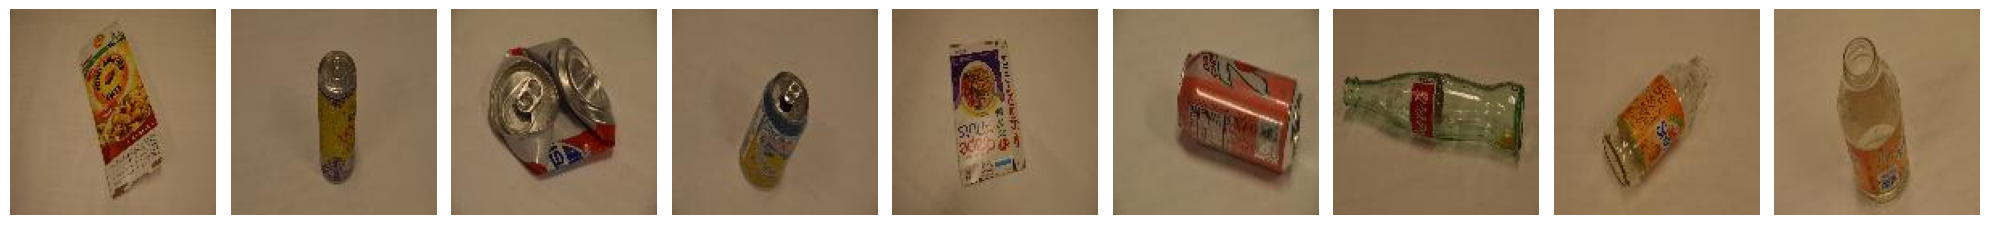

In [171]:
plotImages(x_train)

In [36]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)


#### binary classification

In [38]:
import numpy as np

# Get the indices of the classes you want to keep
keep_classes = [2, 4]
keep_indices = np.isin(y_train, keep_classes)

# Find the indices of the rows in x_train and y_train that correspond to the kept classes
row_indices = np.where(keep_indices)[0]

# Select the rows in X_train and Y_train that correspond to the kept classes
x_train = x_train[row_indices]
y_train = y_train[row_indices]

# Update the Y_train labels to be in the range [0, number of kept classes)
y_train[y_train == keep_classes[0]] = 0
y_train[y_train == keep_classes[1]] = 1




In [39]:
keep_classes = [2, 4]
keep_indices = np.isin(y_test, keep_classes)

# Find the indices of the rows in x_train and y_train that correspond to the kept classes
row_indices = np.where(keep_indices)[0]

# Select the rows in X_train and Y_train that correspond to the kept classes
x_test = x_test[row_indices]
y_test = y_test[row_indices]

# Update the Y_train labels to be in the range [0, number of kept classes)
y_test[y_test == keep_classes[0]] = 0
y_test[y_test == keep_classes[1]] = 1



In [8]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

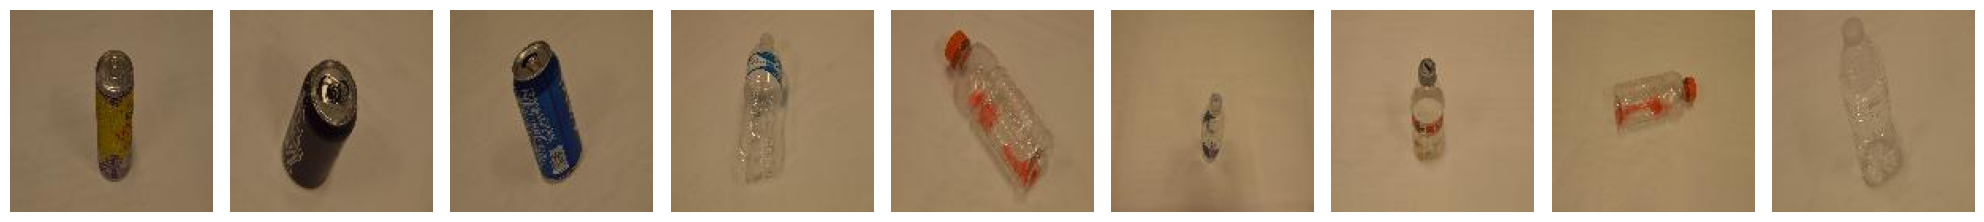

In [46]:
plotImages(x_train[::15])

#### TensorBoard

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [30]:
%reload_ext tensorboard

In [2]:
from tensorflow.keras.callbacks import TensorBoard
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import datetime


In [11]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

callback = [tensorboard_callback,early_stop]

In [3]:

%tensorboard --logdir logs/

## CNN

### no augmenation 

In [13]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32),
                     (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32),
                     (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64),
                     (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Conv2D(hp.Int('conv4_units', min_value=64, max_value=256, step=64),
                     (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256),
                    activation='relu'))
    model.add(Dense(units=5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    
    return model


In [196]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='port_model_tuner'
)


INFO:tensorflow:Reloading Oracle from existing project tuner_directory/port_model_tuner/oracle.json


INFO:tensorflow:Reloading Oracle from existing project tuner_directory/port_model_tuner/oracle.json


INFO:tensorflow:Reloading Tuner from tuner_directory/port_model_tuner/tuner0.json


INFO:tensorflow:Reloading Tuner from tuner_directory/port_model_tuner/tuner0.json


In [197]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))



INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [16]:
port_model = tuner.get_best_models(num_models=1)[0]
port_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
port_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 96)        27744     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        55360     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/Port", histogram_freq=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

callback = [tensorboard_callback,early_stop]

port_model.fit(x_train, y_train, 
               epochs=20, 
               validation_data=(x_val, y_val),
              callbacks = callback)


Epoch 1/20


2023-05-28 13:38:05.608009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-28 13:38:05.791417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.7327

2023-05-28 13:38:25.833468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 24s 80ms/step - loss: 1.1107 - accuracy: 0.7327 - val_loss: 0.6028 - val_accuracy: 0.7730
Epoch 2/20
288/288 [==============================] - 23s 78ms/step - loss: 0.3258 - accuracy: 0.8808 - val_loss: 0.3417 - val_accuracy: 0.8678
Epoch 3/20
288/288 [==============================] - 22s 77ms/step - loss: 0.2308 - accuracy: 0.9177 - val_loss: 0.2872 - val_accuracy: 0.9017
Epoch 4/20
288/288 [==============================] - 23s 78ms/step - loss: 0.1564 - accuracy: 0.9454 - val_loss: 0.2309 - val_accuracy: 0.9174
Epoch 5/20
288/288 [==============================] - 23s 78ms/step - loss: 0.2399 - accuracy: 0.9137 - val_loss: 0.2288 - val_accuracy: 0.9113
Epoch 6/20
288/288 [==============================] - 23s 78ms/step - loss: 0.1261 - accuracy: 0.9560 - val_loss: 0.2228 - val_accuracy: 0.9287
Epoch 7/20
288/288 [==============================] - 23s 78ms/step - loss: 0.1073 - accuracy: 0.9649 - val_loss: 0.2196 - val_accuracy: 0.9270
Epo

In [19]:
test_loss, test_accuracy = port_model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

36/36 [==============================] - 1s 25ms/step - loss: 0.2471 - accuracy: 0.9252
Test loss: 0.24713364243507385
Test accuracy: 0.9252173900604248


In [20]:
# Classification Report
predictions = port_model.predict(x_test)

y_pred = np.argmax(predictions, axis=1)
target_names = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


 3/36 [=>............................] - ETA: 1s

2023-05-28 13:43:52.581772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 24ms/step
                   precision    recall  f1-score   support

            boxes       0.98      0.99      0.98       235
    glass_bottles       0.88      0.94      0.91       233
        soda_cans       0.92      0.86      0.89       234
crushed_soda_cans       0.91      0.98      0.94       242
     water_bottle       0.94      0.84      0.89       206

         accuracy                           0.93      1150
        macro avg       0.93      0.92      0.92      1150
     weighted avg       0.93      0.93      0.92      1150



In [21]:
# Mean Average Precision (mAP)
from sklearn.metrics import average_precision_score

mAP = average_precision_score(y_test, predictions, average='macro')
print("Mean Average Precision (mAP):", mAP)

Mean Average Precision (mAP): 0.9782705012036643


36/36 [==============================] - 1s 24ms/step


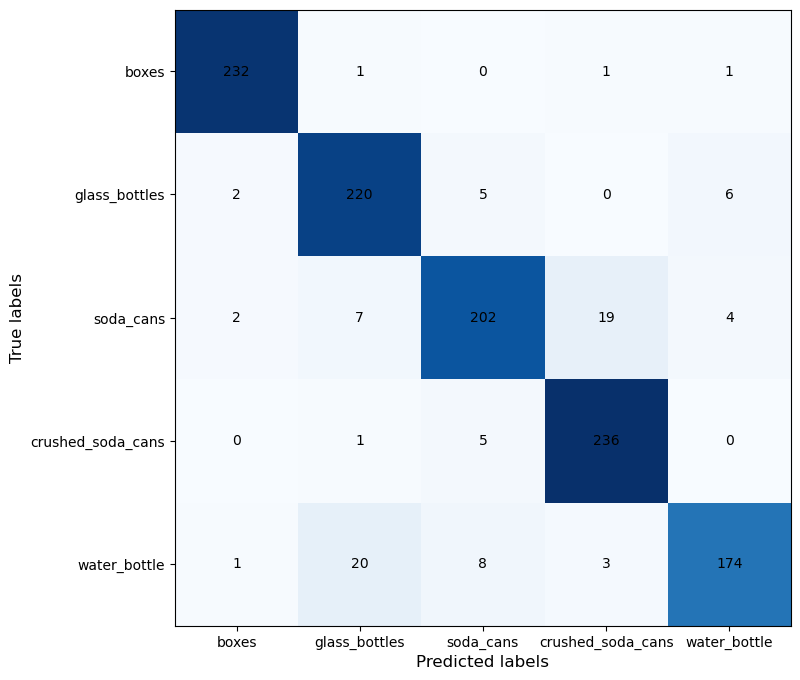

In [23]:
y_pred = port_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


### Transfer Learning VGG16

In [155]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocess the image data
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
x_test = preprocess_input(x_test)


[1. 0. 0. 0. 0.]


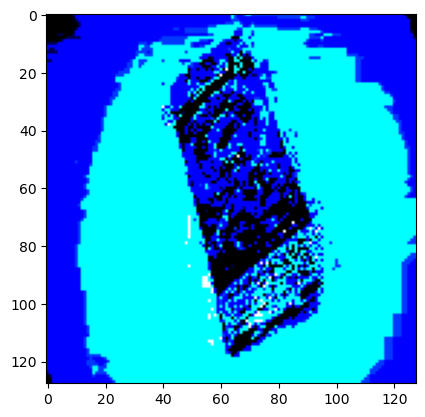

In [156]:
print(y_train[0])
plt.imshow(x_train[0])

In [124]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (classification) layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the new model by adding the classification layers on top of the base model
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(5, activation='softmax')(x)

TL_portmodel = keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model with appropriate loss, optimizer and metrics
TL_portmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
TL_portmodel.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [125]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/TL_portmodel", histogram_freq=1)

callback = [tensorboard_callback]

TL_portmodel.fit( x_train, y_train, batch_size=32,
                    epochs=5, verbose=1,
                    validation_data = (x_val, y_val),
                    callbacks = callback)




Epoch 1/5


2023-05-28 15:11:22.105111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.8304

2023-05-28 15:12:18.949538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 65s 222ms/step - loss: 0.6958 - accuracy: 0.8304 - val_loss: 0.1431 - val_accuracy: 0.9522
Epoch 2/5
288/288 [==============================] - 62s 216ms/step - loss: 0.1595 - accuracy: 0.9426 - val_loss: 0.0881 - val_accuracy: 0.9670
Epoch 3/5
288/288 [==============================] - 66s 229ms/step - loss: 0.1060 - accuracy: 0.9603 - val_loss: 0.0621 - val_accuracy: 0.9800
Epoch 4/5
288/288 [==============================] - 70s 243ms/step - loss: 0.0721 - accuracy: 0.9739 - val_loss: 0.0486 - val_accuracy: 0.9843
Epoch 5/5
288/288 [==============================] - 75s 261ms/step - loss: 0.0609 - accuracy: 0.9782 - val_loss: 0.0510 - val_accuracy: 0.9826


In [127]:
# UnFreeze the weights of the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = True

In [128]:
TL_portmodel.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])


TL_portmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

/Users/abdullah/miniforge3/envs/tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [129]:
# Train the model 
TL_portmodel.fit( x_train, y_train, batch_size=32,
                    epochs=2, verbose=1,
                    validation_data = (x_val, y_val)
                    )


Epoch 1/2


2023-05-28 15:19:09.187475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9802

2023-05-28 15:22:26.597504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 206s 712ms/step - loss: 0.0544 - accuracy: 0.9802 - val_loss: 0.0273 - val_accuracy: 0.9904
Epoch 2/2
288/288 [==============================] - 240s 832ms/step - loss: 0.0228 - accuracy: 0.9921 - val_loss: 0.0197 - val_accuracy: 0.9957


In [130]:
test_loss, test_accuracy = TL_portmodel.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

36/36 [==============================] - 7s 189ms/step - loss: 0.0099 - accuracy: 0.9957
Test loss: 0.009891361929476261
Test accuracy: 0.9956521987915039


In [131]:
# Classification Report
predictions = TL_portmodel.predict(x_test)

y_pred = np.argmax(predictions, axis=1)
target_names = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


2023-05-28 15:29:54.092480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 8s 207ms/step
                   precision    recall  f1-score   support

            boxes       1.00      1.00      1.00       235
    glass_bottles       0.99      1.00      0.99       233
        soda_cans       1.00      0.99      0.99       234
crushed_soda_cans       0.99      1.00      1.00       242
     water_bottle       1.00      1.00      1.00       206

         accuracy                           1.00      1150
        macro avg       1.00      1.00      1.00      1150
     weighted avg       1.00      1.00      1.00      1150



In [132]:
# Mean Average Precision (mAP)

mAP = average_precision_score(y_test, predictions, average='macro')
print("Mean Average Precision (mAP):", mAP)

Mean Average Precision (mAP): 0.9999512039653133


36/36 [==============================] - 7s 210ms/step


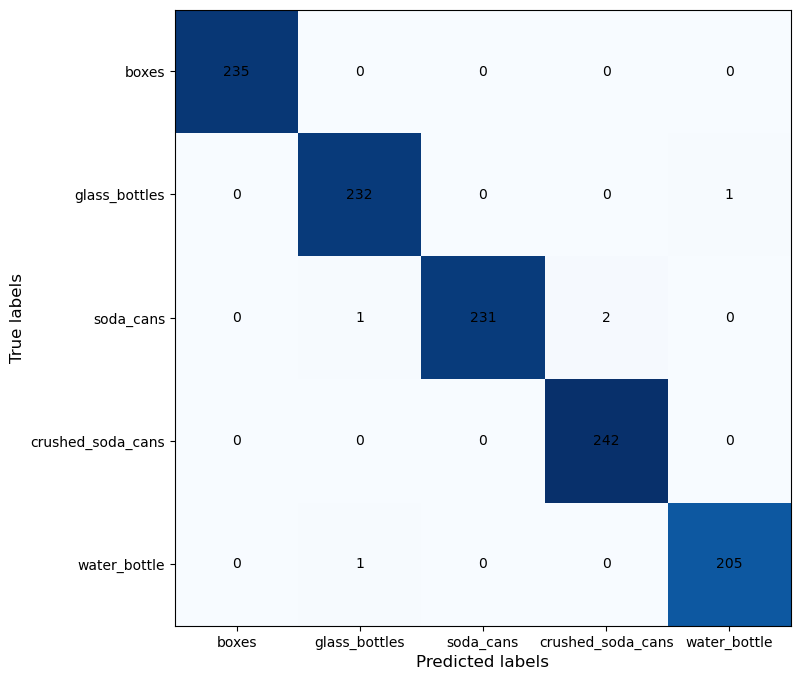

In [133]:
y_pred = TL_portmodel.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


In [134]:
TL_portmodel.save('TL_Port')

INFO:tensorflow:Assets written to: TL_Port/assets


INFO:tensorflow:Assets written to: TL_Port/assets


#### Converting the best model to TFlite

In [139]:
##### converting the model in tflite and using the default optimization from tf


# Load the saved model
tf_model = tf.keras.models.load_model('TL_Port')

# Create the converter and optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert the model to tflite
tflite_model = converter.convert()

# Save the converted model
with open('modelPort.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpaggvg4n8/assets


INFO:tensorflow:Assets written to: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpaggvg4n8/assets
2023-05-28 15:38:01.440168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-28 15:38:01.440182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-28 15:38:01.440324: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpaggvg4n8
2023-05-28 15:38:01.444056: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-05-28 15:38:01.444067: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpaggvg4n8
2023-05-28 15:38:01.449648: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-05-28 15:38:01.536936: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [157]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="modelPort.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare the test data
# Assuming you have x_test and y_test as the test data

# Iterate through the test data and evaluate the model accuracy
correct_predictions = 0
total_predictions = 0

for i in range(len(x_test)):
    image = x_test[i]
    label = y_test[i]

    # Set the input tensor to the input image
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(image, axis=0))

    # Run inference on the TensorFlow Lite model
    interpreter.invoke()

    # Get the output tensor
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Calculate the number of correct predictions
    predicted_class = np.argmax(predictions)
    true_class = np.argmax(label)
    if predicted_class == true_class:
        correct_predictions += 1
    total_predictions += 1

# Calculate the accuracy of the model
accuracy = correct_predictions / total_predictions
print("Model accuracy:", accuracy)


Model accuracy: 0.9956521739130435


### with augmenation 

In [219]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255  # Normalize pixel values between 0 and 1
)

# Create the generator for the training data
train_generator = datagen.flow(
    x_train, y_train,
    batch_size=32
)

# Create the generator for the vla data
val_generator = datagen.flow(
   x_val, y_val,
    batch_size=32
)


In [226]:
# Create the ImageDataGenerator for test data with rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create the test generator
test_generator = test_datagen.flow(
    x_test,  # Input data
    y_test,             # Labels (if applicable)
    batch_size=32,      # Batch size
    shuffle=False       # No shuffling for evaluation
)

In [220]:
port_model2 = tuner.get_best_models(num_models=1)[0]
port_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [221]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/Port-aug", histogram_freq=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

callback = [tensorboard_callback,early_stop]


port_model2.fit(train_generator, 
               epochs=25, 
               validation_data= val_generator,
              callbacks = callback)


Epoch 1/25


2023-05-30 16:18:10.947420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - ETA: 0s - loss: 0.9173 - accuracy: 0.6346

2023-05-30 16:18:42.083389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 37s 123ms/step - loss: 0.9173 - accuracy: 0.6346 - val_loss: 0.6892 - val_accuracy: 0.7287
Epoch 2/25
288/288 [==============================] - 34s 119ms/step - loss: 0.5888 - accuracy: 0.7679 - val_loss: 0.4148 - val_accuracy: 0.8339
Epoch 3/25
288/288 [==============================] - 31s 108ms/step - loss: 0.4110 - accuracy: 0.8501 - val_loss: 0.3983 - val_accuracy: 0.8522
Epoch 4/25
288/288 [==============================] - 32s 112ms/step - loss: 0.3480 - accuracy: 0.8737 - val_loss: 0.2418 - val_accuracy: 0.9122
Epoch 5/25
288/288 [==============================] - 34s 116ms/step - loss: 0.2639 - accuracy: 0.9022 - val_loss: 0.2701 - val_accuracy: 0.9009
Epoch 6/25
288/288 [==============================] - 41s 143ms/step - loss: 0.2345 - accuracy: 0.9125 - val_loss: 0.3300 - val_accuracy: 0.8765
Epoch 7/25
288/288 [==============================] - 37s 128ms/step - loss: 0.2036 - accuracy: 0.9273 - val_loss: 0.3432 - val_accuracy: 0.8

In [227]:
test_loss, test_accuracy = port_model2.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

36/36 [==============================] - 1s 28ms/step - loss: 0.1299 - accuracy: 0.9548
Test loss: 0.12985964119434357
Test accuracy: 0.9547826051712036


In [230]:
# Classification Report
predictions = port_model2.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
target_names = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


 1/36 [..............................] - ETA: 7s

2023-05-30 16:32:55.835104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 24ms/step
                   precision    recall  f1-score   support

            boxes       1.00      0.98      0.99       235
    glass_bottles       0.97      0.97      0.97       233
        soda_cans       0.96      0.88      0.92       234
crushed_soda_cans       0.90      0.99      0.94       242
     water_bottle       0.95      0.95      0.95       206

         accuracy                           0.95      1150
        macro avg       0.96      0.95      0.95      1150
     weighted avg       0.96      0.95      0.95      1150



In [232]:
# Mean Average Precision (mAP)
from sklearn.metrics import average_precision_score

mAP = average_precision_score(y_test, predictions, average='macro')
print("Mean Average Precision (mAP):", mAP)

Mean Average Precision (mAP): 0.9920713569520476


36/36 [==============================] - 1s 24ms/step


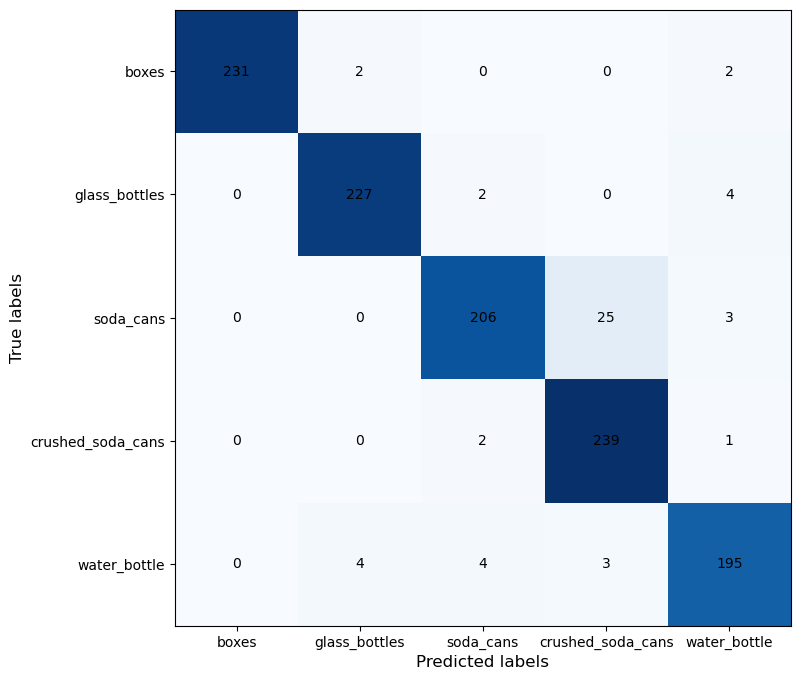

In [233]:
y_pred = port_model2.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


### Binary

In [75]:
port_model2 = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(units = 2, activation='softmax')
])

port_model2.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])

multiple runs same cell

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    
)

# Create the generator for the training data
train_generator = datagen.flow(
    x_train, y_train,
    batch_size=32
)

# Train the model using the generator
port_model2.fit(
    train_generator,
    steps_per_epoch=len(x_train) / 32,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
115/115 [==============================] - 8s 69ms/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 0.0333 - val_accuracy: 0.9880
Epoch 2/100
115/115 [==============================] - 7s 64ms/step - loss: 0.0390 - accuracy: 0.9883 - val_loss: 0.0185 - val_accuracy: 0.9924
Epoch 3/100
115/115 [==============================] - 8s 65ms/step - loss: 0.0594 - accuracy: 0.9818 - val_loss: 0.0237 - val_accuracy: 0.9880
Epoch 4/100
115/115 [==============================] - 8s 67ms/step - loss: 0.0299 - accuracy: 0.9886 - val_loss: 0.0382 - val_accuracy: 0.9870
Epoch 5/100
115/115 [==============================] - 8s 67ms/step - loss: 0.0295 - accuracy: 0.9897 - val_loss: 0.0931 - val_accuracy: 0.9837


In [81]:
test_loss, test_accuracy = port_model2.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)



29/29 [==============================] - 1s 23ms/step - loss: 0.0931 - accuracy: 0.9837
Test loss: 0.09311582148075104
Test accuracy: 0.9836956858634949


29/29 [==============================] - 1s 23ms/step


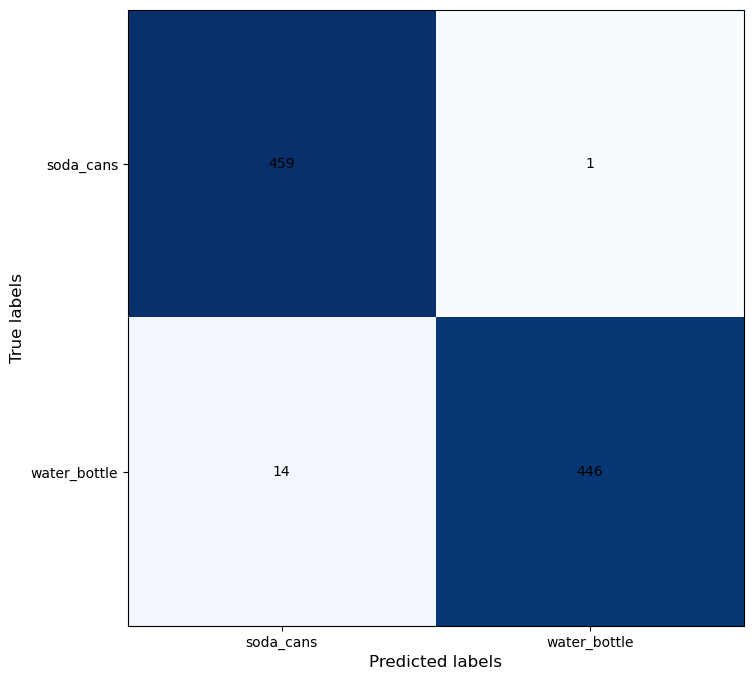

In [84]:
y_pred = port_model2.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = {0: 'soda_cans', 1: 'water_bottle'}

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels([label_map[i] for i in range(2)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(2)])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


## RF

In [131]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Define the hyperparameters to test
param_grid = {'n_estimators': [10, 50, 100,200],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a random forest classifier
rfc = RandomForestClassifier()

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(x_train_flat, y_train.ravel())

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8009782608695651


In [162]:
rf_model = RandomForestClassifier(n_estimators = 200, max_depth= None,min_samples_leaf = 1, min_samples_split = 2 )

rf_model.fit(x_train_flat,y_train.ravel())

y_rf = rf_model.predict(x_test_flat)

In [164]:
##### accuracy score of the Random Forrest
score_rf = round(accuracy_score(y_test.ravel(),y_rf)*100, 3)
print("Accuracy score: ",score_rf,"%\n\n")

Accuracy score:  80.217 %




In [169]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

y_pred = rf_model.predict(x_test_flat)  # Compute the predicted labels

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))

print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.8021739130434783
Precision: 0.801646113960192
Recall: 0.8021739130434782
F1-score: 0.8017511300672358
                   precision    recall  f1-score   support

            boxes       0.89      0.92      0.91       460
    glass_bottles       0.77      0.78      0.77       460
        soda_cans       0.72      0.71      0.71       460
crushed_soda_cans       0.79      0.80      0.79       460
     water_bottle       0.84      0.80      0.82       460

         accuracy                           0.80      2300
        macro avg       0.80      0.80      0.80      2300
     weighted avg       0.80      0.80      0.80      2300



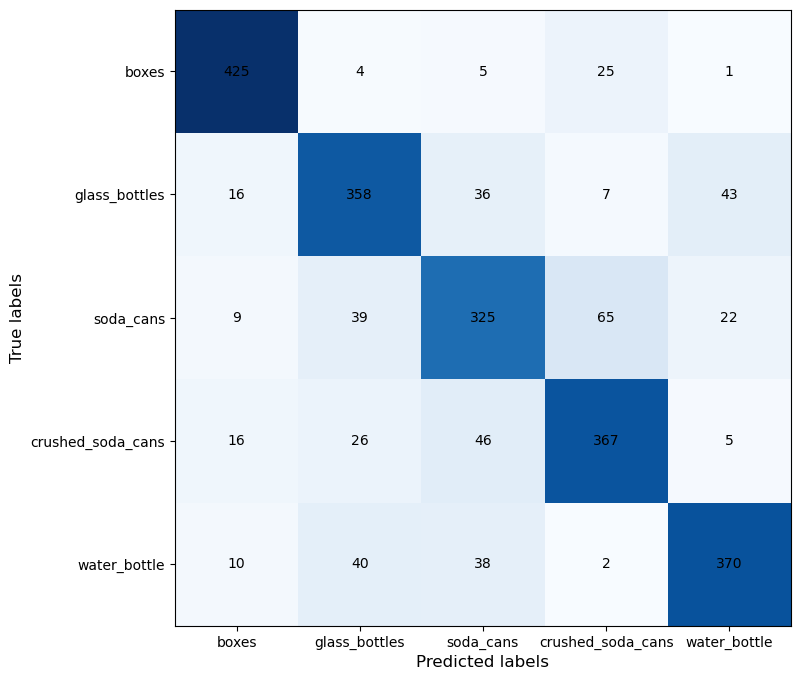

In [170]:
y_pred = rf_model.predict(x_test_flat)

# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred)

label_map = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']



# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

2 classes

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Define the hyperparameters to test
param_grid = {'n_estimators': [10,100,200],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a random forest classifier
rfc2 = RandomForestClassifier()

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(estimator=rfc2, param_grid=param_grid)
grid_search.fit(x_train_flat, y_train.ravel())

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8991847826086957


In [151]:
rf_model2 = RandomForestClassifier(n_estimators = 200, max_depth= None,min_samples_leaf = 1, min_samples_split = 2 )

rf_model2.fit(x_train_flat,y_train.ravel())

y_rf = rf_model2.predict(x_test_flat)

##### accuracy score of the Random Forrest

score_rf = round(accuracy_score(y_test.ravel(),y_rf)*100, 3)
print("Accuracy score: ",score_rf,"%\n\n")

Accuracy score:  90.87 %




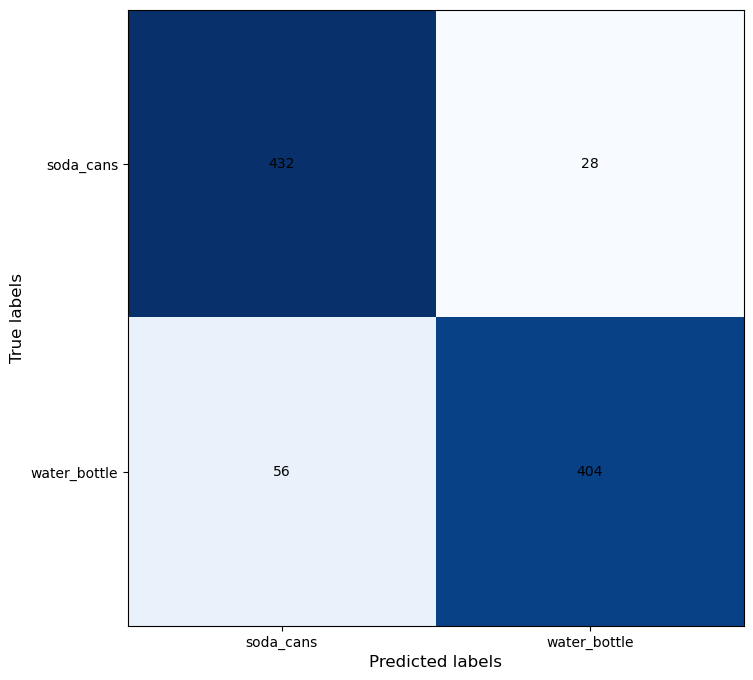

In [152]:
y_pred = rf_model2.predict(x_test_flat)

# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred)
label_map = {0: 'soda_cans', 1: 'water_bottle'}



# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels([label_map[i] for i in range(2)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(2)])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

## SVM

In [8]:
from sklearn.svm import SVC
svm = SVC(C =23.148804239663594, degree= 2, kernel = 'rbf')

svm.fit(x_train_flat,y_train.ravel())

y_svm = svm.predict(x_test_flat)

##### accuracy score of svm model

score_svm = round(accuracy_score(y_test.ravel(),y_svm)*100, 3)
print("Accuracy score: ",score_svm,"%\n\n")

Accuracy score:  86.478 %




In [9]:
from sklearn.metrics import classification_report

#y_pred = svm.predict(x_test_flat)  # Compute the predicted labels
target_names = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']

print(classification_report(y_test, y_svm, target_names=target_names))


                   precision    recall  f1-score   support

            boxes       0.94      0.97      0.95       460
    glass_bottles       0.85      0.87      0.85       460
        soda_cans       0.77      0.81      0.79       460
crushed_soda_cans       0.87      0.78      0.82       460
     water_bottle       0.91      0.90      0.91       460

         accuracy                           0.86      2300
        macro avg       0.87      0.86      0.86      2300
     weighted avg       0.87      0.86      0.86      2300



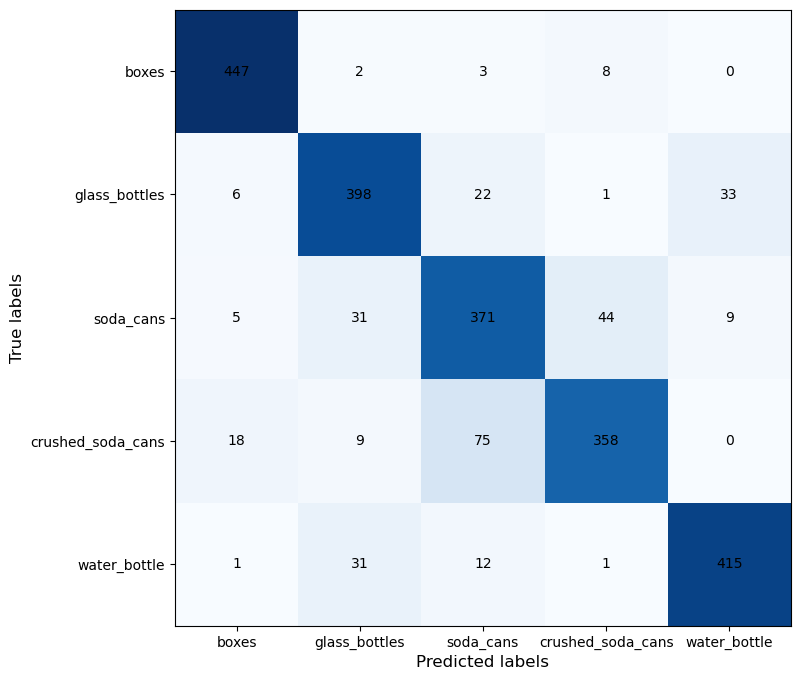

In [10]:

# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_svm)

label_map = {0: 'boxes', 1: 'glass_bottles', 2: 'soda_cans', 3: 'crushed_soda_cans', 4: 'water_bottle'}



# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

#### Binary classification

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy

# Define the hyperparameters to test
param_dist = {'C': scipy.stats.expon(scale=10), 
              'kernel': ['linear', 'poly', 'rbf'], 
              'shrinking': [True, False],
              'degree': [1, 2, 3, 4, 5]}

# Create an SVM object
svm = SVC()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(svm, param_distributions=param_dist)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(x_train_flat, y_train.ravel())

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)



Best hyperparameters: {'C': 23.148804239663594, 'degree': 2, 'kernel': 'rbf', 'shrinking': False}
Best cross-validation score: 0.95625


In [11]:
svm2 = SVC(C =23.148804239663594, degree= 2, kernel = 'rbf', shrinking= False)

svm2.fit(x_train_flat,y_train.ravel())

y_svm = svm2.predict(x_test_flat)

##### accuracy score of svm model

score_svm = round(accuracy_score(y_test.ravel(),y_svm)*100, 3)
print("Accuracy score: ",score_svm,"%\n\n")

Accuracy score:  96.087 %




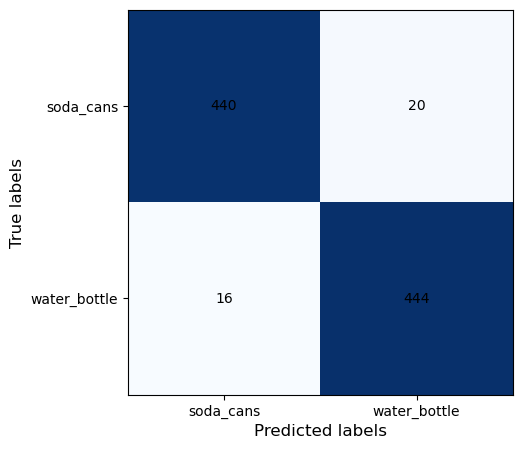

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_svm)
label_map = {0: 'soda_cans', 1: 'water_bottle'}



# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels([label_map[i] for i in range(2)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(2)])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

## KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to test
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(x_train_flat, y_train.ravel())

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best hyperparameters: {'n_neighbors': 1}
Best cross-validation score: 0.6133695652173914


Text(0, 0.5, 'Testing Accuracy')

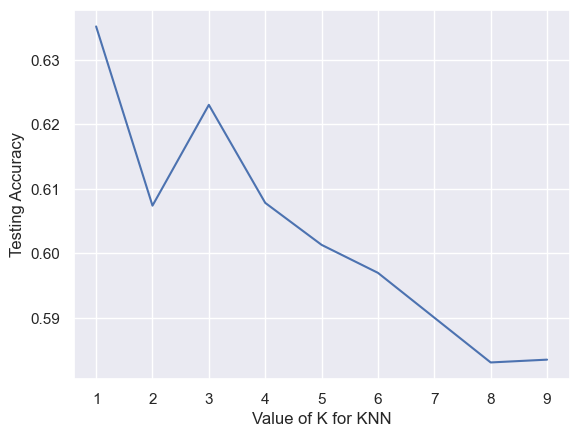

In [37]:
k_range = range(1, 10)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
    knn.fit(x_train_flat, y_train.ravel())
    y_knn = knn.predict(x_test_flat)
    scores.append(accuracy_score(y_test.ravel(), y_knn))
    
    
sns.set_theme(style='darkgrid')    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')


In [13]:
# create a KNN model with k=1
knn = KNeighborsClassifier(n_neighbors=1)

# fit the model on the training data
knn.fit(x_train_flat, y_train.ravel())

# evaluate the model on the test data
score = round(knn.score(x_test_flat, y_test.ravel())*100, 5)
print("Test accuracy:", score)

Test accuracy: 63.52174


In [15]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

#y_pred = svm.predict(x_test_flat)  # Compute the predicted labels
target_names = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']



print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

            boxes       1.00      0.26      0.42       460
    glass_bottles       0.61      0.75      0.67       460
        soda_cans       0.61      0.75      0.67       460
crushed_soda_cans       0.81      0.52      0.63       460
     water_bottle       0.55      0.89      0.68       460

         accuracy                           0.64      2300
        macro avg       0.71      0.64      0.61      2300
     weighted avg       0.71      0.64      0.61      2300



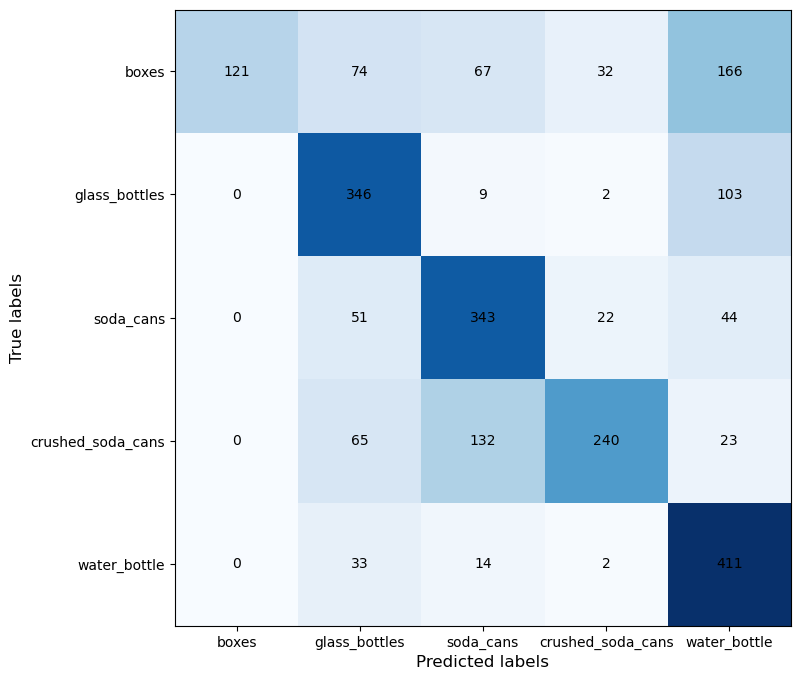

In [14]:
y_pred = knn.predict(x_test_flat)

# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred)

label_map = {0: 'boxes', 1: 'glass_bottles', 2: 'soda_cans', 3: 'crushed_soda_cans', 4: 'water_bottle'}



# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

2 classes

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to test
param_grid = {'n_neighbors': [1, 2, 3, 4]}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Perform a grid search over the hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(x_train_flat, y_train.ravel())

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best hyperparameters: {'n_neighbors': 4}
Best cross-validation score: 0.9070652173913043


In [146]:
# create a KNN model with k=1
knn2 = KNeighborsClassifier(n_neighbors=4)

# fit the model on the training data
knn2.fit(x_train_flat, y_train.ravel())

# evaluate the model on the test data
score = round(knn2.score(x_test_flat, y_test.ravel())*100, 5)
print("Test accuracy:", score)

Test accuracy: 90.43478


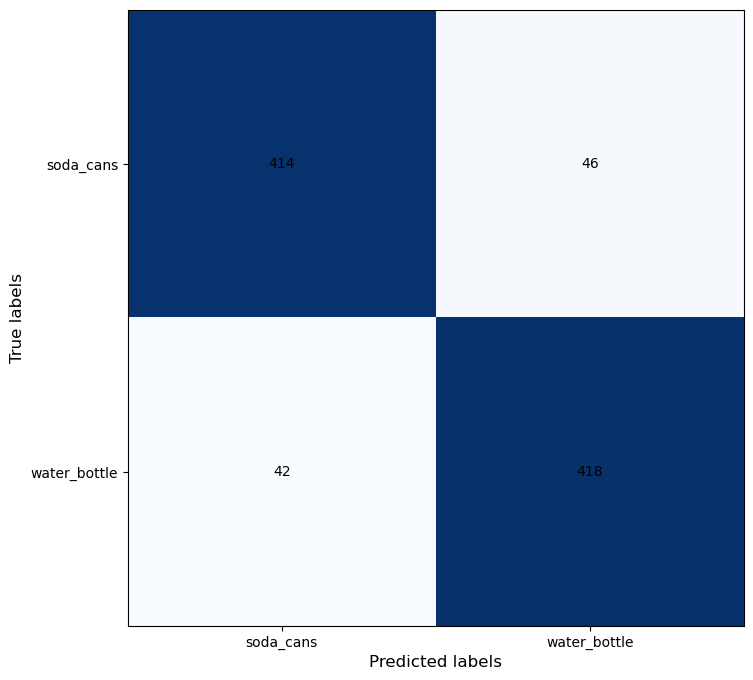

In [148]:
y_pred = knn2.predict(x_test_flat)

# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred)
label_map = {0: 'soda_cans', 1: 'water_bottle'}



# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels([label_map[i] for i in range(2)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(2)])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

## MLP 

In [108]:
from kerastuner import HyperModel


class MLPModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Flatten(input_shape=(128, 128, 3)))
        for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
            model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                            activation='relu'))
        model.add(Dense(5, activation='softmax'))
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


In [109]:
tuner = RandomSearch(
    MLPModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_directory',
    project_name='mlp_tuning'
)


INFO:tensorflow:Reloading Oracle from existing project tuner_directory/mlp_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_directory/mlp_tuning/tuner0.json


In [110]:
tuner.search( x_train, y_train,
             epochs=10,
             validation_data=(x_val, y_val))


INFO:tensorflow:Oracle triggered exit


In [111]:
mlp_model = tuner.get_best_models(num_models=1)[0]

In [112]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 224)               11010272  
                                                                 
 dense_1 (Dense)             (None, 32)                7200      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 11,017,637
Trainable params: 11,017,637
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Train the model using the training data
## 3 epochs bc accuarcy drops to 20% after that

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/MLP", histogram_freq=1)

#early_stop = EarlyStopping(monitor='val_loss', patience=5)

callback = [tensorboard_callback]


mlp_model.fit(
    x_train, y_train, 
               epochs=3, 
               validation_data=(x_val, y_val),
              callbacks = callback
)

Epoch 1/3


2023-05-28 15:00:10.392442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - ETA: 0s - loss: 182.3782 - accuracy: 0.4800

2023-05-28 15:00:19.585678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 13s 44ms/step - loss: 182.3782 - accuracy: 0.4800 - val_loss: 68.1579 - val_accuracy: 0.6243
Epoch 2/3
288/288 [==============================] - 11s 39ms/step - loss: 119.1107 - accuracy: 0.4997 - val_loss: 173.1709 - val_accuracy: 0.3504
Epoch 3/3
288/288 [==============================] - 11s 40ms/step - loss: 97.1178 - accuracy: 0.5097 - val_loss: 88.5945 - val_accuracy: 0.4252


In [114]:
# Classification Report
predictions = mlp_model.predict(x_test)

y_pred = np.argmax(predictions, axis=1)
target_names = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

mAP = average_precision_score(y_test, predictions, average='macro')
print("Mean Average Precision (mAP):", mAP)


14/36 [==========>...................] - ETA: 0s

2023-05-28 15:00:49.111157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 14ms/step
                   precision    recall  f1-score   support

            boxes       0.74      0.81      0.77       235
    glass_bottles       0.63      0.39      0.48       233
        soda_cans       0.28      0.88      0.43       234
crushed_soda_cans       0.71      0.06      0.11       242
     water_bottle       1.00      0.00      0.01       206

         accuracy                           0.44      1150
        macro avg       0.67      0.43      0.36      1150
     weighted avg       0.67      0.44      0.37      1150

Mean Average Precision (mAP): 0.43673599034371013


In [115]:
test_loss, test_accuracy = mlp_model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


36/36 [==============================] - 1s 19ms/step - loss: 81.0385 - accuracy: 0.4383
Test loss: 81.0384521484375
Test accuracy: 0.43826088309288025


36/36 [==============================] - 1s 15ms/step


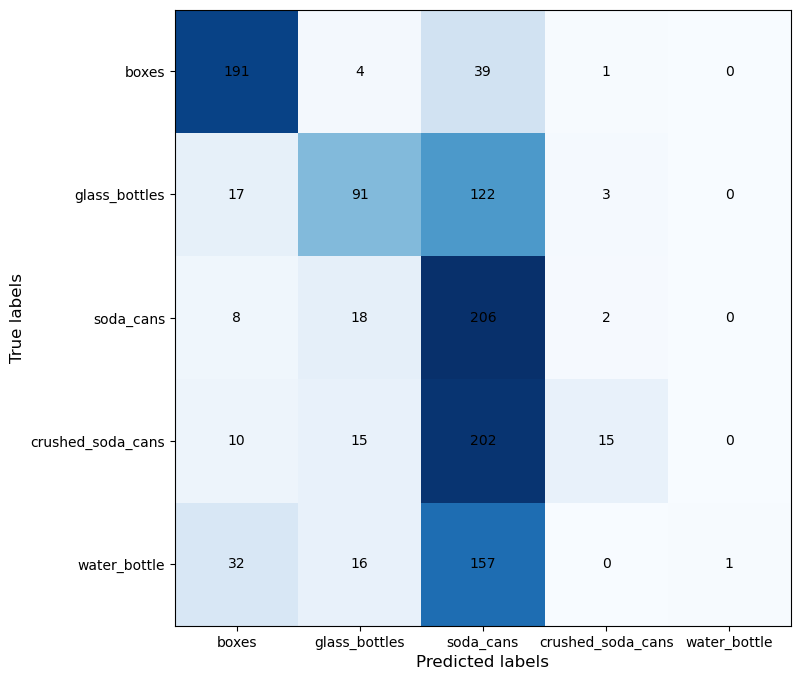

In [116]:
y_pred = mlp_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = ['boxes', 'glass_bottles', 'soda_cans', 'crushed_soda_cans', 'water_bottle']

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(5))
ax.yaxis.set(ticks=range(5))
ax.xaxis.set_ticklabels([label_map[i] for i in range(5)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(5)])
for i in range(5):
    for j in range(5):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


2 classes

In [135]:
# Define the model
mlp_model2 = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
mlp_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [136]:
# Train the model using the training data

mlp_model2.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10


2023-03-13 04:40:50.230258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 1195.5555 - accuracy: 0.6745

2023-03-13 04:40:54.048436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 5s 34ms/step - loss: 1195.5555 - accuracy: 0.6745 - val_loss: 98.1564 - val_accuracy: 0.7870
Epoch 2/10
115/115 [==============================] - 4s 33ms/step - loss: 158.7802 - accuracy: 0.7383 - val_loss: 95.8878 - val_accuracy: 0.7609
Epoch 3/10
115/115 [==============================] - 4s 33ms/step - loss: 59.2879 - accuracy: 0.7951 - val_loss: 49.2072 - val_accuracy: 0.7413
Epoch 4/10
115/115 [==============================] - 4s 32ms/step - loss: 47.2359 - accuracy: 0.7842 - val_loss: 58.8825 - val_accuracy: 0.6793
Epoch 5/10
115/115 [==============================] - 4s 31ms/step - loss: 25.1901 - accuracy: 0.8060 - val_loss: 57.7572 - val_accuracy: 0.5848
Epoch 6/10
115/115 [==============================] - 3s 30ms/step - loss: 32.6267 - accuracy: 0.7780 - val_loss: 21.8566 - val_accuracy: 0.7859
Epoch 7/10
115/115 [==============================] - 4s 31ms/step - loss: 49.4099 - accuracy: 0.7546 - val_loss: 55.6645 - val_accuracy: 

In [137]:
test_loss, test_accuracy = mlp_model2.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


29/29 [==============================] - 1s 19ms/step - loss: 4.6967 - accuracy: 0.7663
Test loss: 4.6967291831970215
Test accuracy: 0.7663043737411499


29/29 [==============================] - 1s 22ms/step


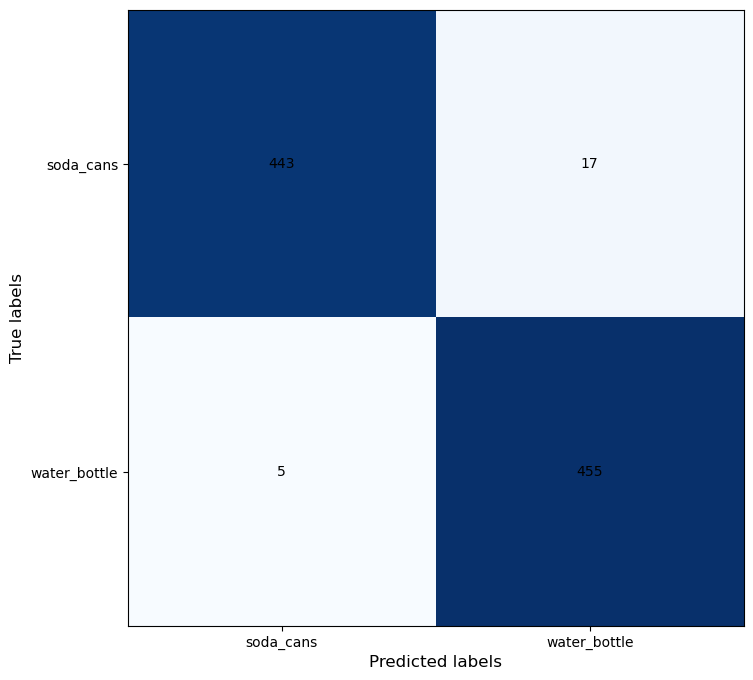

In [139]:
y_pred = port_model_noaug2.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = {0: 'soda_cans', 1: 'water_bottle'}

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels([label_map[i] for i in range(2)])
ax.yaxis.set_ticklabels([label_map[i] for i in range(2)])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


# Convolutional Neural Networks Classify Waste on a Raspberry Pi  

Since the CNN got the highest accuarcy we will compare CNNs to classify waste objects and the best model will be converted into TF-lite and deployed into the raspberrypi. 

### Overview of Dataset

The dataset that will be used for this task is from Roboflow: https://universe.roboflow.com/recycle/recyclable-items/dataset/3 \
This is an object detection dataset that contains the classes below:

- Plastic with 11919 train images
- Metal with 6855 train images
- Glass with 2200 train images

### What will be done

- This part of the project will focus on the classification of two classes: Plastic & Metals
- A simple 8 layer CNN will be used firstly
- Transferlearning will be used for the second part

## Roboflow DS

In [9]:
train_path = '/Users/abdullah/Desktop/GP-impl/Recyclable-Items-2/train'
valid_path = '/Users/abdullah/Desktop/GP-impl/Recyclable-Items-2/valid'
test_path = '/Users/abdullah/Desktop/GP-impl/Recyclable-Items-2/test'

In [10]:
## train
annotations_path = '/Users/abdullah/Desktop/GP-impl/Recyclable-Items-2/train/_annotations.csv'
annotations = pd.read_csv(annotations_path)

# Drop the rows with label 'glass'
annotations = annotations[annotations['class'] != "glass"]

## valid
annotations_path = '/Users/abdullah/Desktop/GP-impl/Recyclable-Items-2/valid/_annotations.csv'
annotations_valid = pd.read_csv(annotations_path)

# Drop the rows with label 'glass'
annotations_valid = annotations_valid[annotations_valid['class'] != "glass"]

## test
annotations_path = '/Users/abdullah/Desktop/GP-impl/Recyclable-Items-2/test/_annotations.csv'
annotations_test = pd.read_csv(annotations_path)

# Drop the rows with label 'glass'
annotations_test = annotations_test[annotations_test['class'] != "glass"]

In [11]:
annotations['class'].value_counts() 

plastic    11919
metal       6855
Name: class, dtype: int64

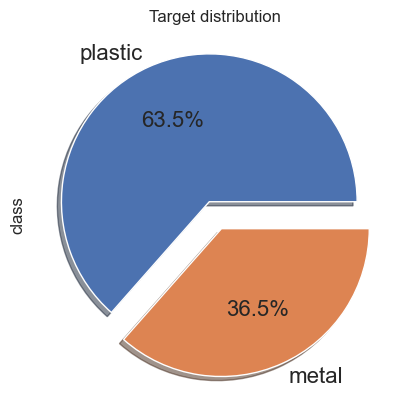

In [12]:
sns.set_theme(style='darkgrid')
annotations['class'].value_counts() .plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")
plt.show()

In [13]:
##data aug

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=annotations,
    directory=train_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=annotations_valid,
    directory=valid_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')



Found 18774 validated image filenames belonging to 2 classes.
Found 1733 validated image filenames belonging to 2 classes.


In [14]:
# Set up the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=annotations_test,
    directory=test_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)



Found 826 validated image filenames belonging to 2 classes.


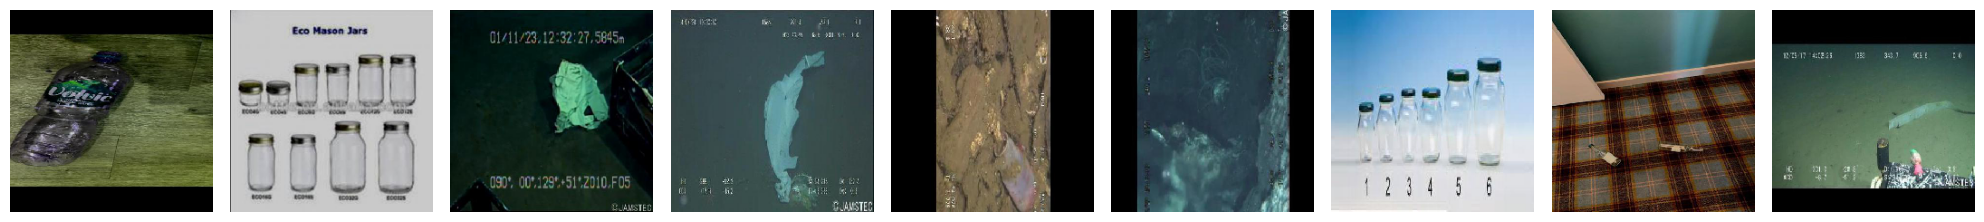

In [20]:
imgs, labels = next(val_generator)
plotImages(imgs)

### EfficientNet

In [17]:
from tensorflow.keras.applications import EfficientNetB0
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = keras.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    
    # Tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=128, max_value=512, step=64)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))

    # Customize the optimizer and its learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [18]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_directory',
    project_name='efficientnet_tuner'
)


tuner.search(train_generator, epochs=2, validation_data=val_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Reloading Oracle from existing project tuner_directory/efficientnet_tuner/oracle.json
Metal device set to: Apple M1


2023-06-05 12:27:04.995978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-05 12:27:04.996092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Reloading Tuner from tuner_directory/efficientnet_tuner/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [19]:
model = tuner.get_best_models(num_models=1)[0]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 384)               491904    
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 770       
                                                                 
Total params: 4,542,245
Trainable params: 492,674
Non-trainable params: 4,049,571
________________________________________

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/EfficientNet_Robo", histogram_freq=1)


callback = [tensorboard_callback]

model.fit(
    x = train_generator,
    validation_data=val_generator,
    epochs=3,
    verbose=1,
    callbacks = callback
    
)

Epoch 1/3


2023-06-05 12:27:15.140955: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-05 12:27:16.667168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.6279

2023-06-05 12:29:45.515378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - 164s 275ms/step - loss: 0.6678 - accuracy: 0.6279 - val_loss: 0.6566 - val_accuracy: 0.6353
Epoch 2/3
587/587 [==============================] - 177s 300ms/step - loss: 0.6593 - accuracy: 0.6349 - val_loss: 0.6561 - val_accuracy: 0.6353
Epoch 3/3
587/587 [==============================] - 181s 307ms/step - loss: 0.6579 - accuracy: 0.6349 - val_loss: 0.6586 - val_accuracy: 0.6353


In [84]:
# UnFreeze the weights of the pre-trained layers in the base model
for layer in model.layers:
    layer.trainable = True

In [85]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 4,706,469
Trainable params: 4,664,446
Non-trainable params: 42,023
_________________________________________

In [86]:
model.fit(
    x = train_generator,
    validation_data=val_generator,
    epochs=2,
    verbose=1,
callbacks = callback
    
)

Epoch 1/2


2023-06-04 22:14:46.011162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8568

2023-06-04 22:28:39.945525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - 865s 1s/step - loss: 0.3293 - accuracy: 0.8568 - val_loss: 0.7356 - val_accuracy: 0.6353
Epoch 2/2
587/587 [==============================] - 744s 1s/step - loss: 0.2129 - accuracy: 0.9122 - val_loss: 4.6048 - val_accuracy: 0.6261


In [87]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

26/26 [==============================] - 11s 410ms/step - loss: 4.8119 - accuracy: 0.6453
Test Loss: 4.811854362487793
Test Accuracy: 0.6452784538269043


2023-06-04 22:41:44.119656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 18s 555ms/step


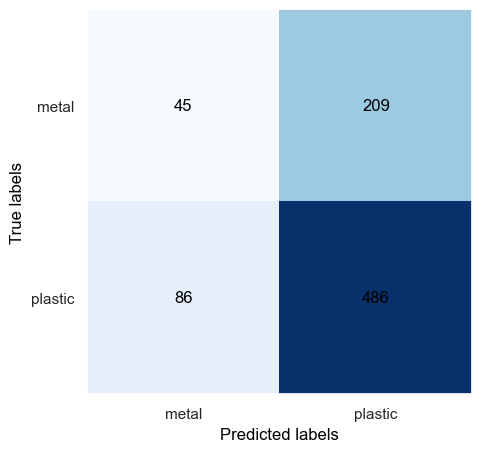

In [88]:
# Get the predicted labels for the test set
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=test_generator.classes, predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels(['metal', 'plastic'])
ax.yaxis.set_ticklabels(['metal', 'plastic'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

In [89]:


target_names = ['metal', 'plastic']
print(classification_report(test_generator.classes, y_pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       metal       0.34      0.18      0.23       254
     plastic       0.70      0.85      0.77       572

    accuracy                           0.64       826
   macro avg       0.52      0.51      0.50       826
weighted avg       0.59      0.64      0.60       826



### Using Transfer Learning Xception Model

In [21]:
from tensorflow.keras.applications import Xception

# Load the Xception model 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the classification layers
model2 = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,386,538
Trainable params: 525,058
Non-trainable params: 20,861,480
____________________________________

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/Transfer_Robo", histogram_freq=1)


callback = [tensorboard_callback]

model2.fit(
    x = train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1,
    callbacks = callback
    
)

Epoch 1/5


2023-06-05 12:36:25.958300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7929

2023-06-05 12:43:33.336046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - 468s 796ms/step - loss: 0.4480 - accuracy: 0.7929 - val_loss: 0.2727 - val_accuracy: 0.8840
Epoch 2/5
587/587 [==============================] - 541s 921ms/step - loss: 0.3866 - accuracy: 0.8232 - val_loss: 0.2836 - val_accuracy: 0.8702
Epoch 3/5
587/587 [==============================] - 551s 939ms/step - loss: 0.3675 - accuracy: 0.8333 - val_loss: 0.2697 - val_accuracy: 0.8881
Epoch 4/5
587/587 [==============================] - 555s 945ms/step - loss: 0.3614 - accuracy: 0.8322 - val_loss: 0.2460 - val_accuracy: 0.8967
Epoch 5/5
587/587 [==============================] - 555s 946ms/step - loss: 0.3476 - accuracy: 0.8433 - val_loss: 0.2461 - val_accuracy: 0.8932


In [93]:
# UnFreeze the weights of the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = True

In [94]:
from tensorflow.keras.optimizers import Adam

model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])


model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,386,538
Trainable params: 21,332,010
Non-trainable params: 54,528
_____________________________________

/Users/abdullah/miniforge3/envs/tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [95]:
model2.fit(
    x = train_generator,
    validation_data=val_generator,
    epochs=3,
    verbose=1
)

Epoch 1/3


2023-06-04 23:33:36.134596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8242

2023-06-05 00:00:26.582325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


587/587 [==============================] - 1659s 3s/step - loss: 0.3740 - accuracy: 0.8242 - val_loss: 0.2410 - val_accuracy: 0.9059
Epoch 2/3
587/587 [==============================] - 1603s 3s/step - loss: 0.2510 - accuracy: 0.8902 - val_loss: 0.1945 - val_accuracy: 0.9238
Epoch 3/3
587/587 [==============================] - 1593s 3s/step - loss: 0.2058 - accuracy: 0.9131 - val_loss: 0.1834 - val_accuracy: 0.9325


In [101]:
model2.fit(
    x = train_generator,
    validation_data=val_generator,
    epochs=3,
    verbose=1
)

Epoch 1/3
587/587 [==============================] - 1142s 2s/step - loss: 0.1334 - accuracy: 0.9460 - val_loss: 0.1700 - val_accuracy: 0.9308
Epoch 2/3
587/587 [==============================] - 1485s 3s/step - loss: 0.1237 - accuracy: 0.9495 - val_loss: 0.1767 - val_accuracy: 0.9302
Epoch 3/3
587/587 [==============================] - 1568s 3s/step - loss: 0.1063 - accuracy: 0.9579 - val_loss: 0.1838 - val_accuracy: 0.9388


In [27]:
test_loss, test_accuracy = model2.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

26/26 [==============================] - 12s 453ms/step - loss: 0.1271 - accuracy: 0.9661
Test Loss: 0.12708115577697754
Test Accuracy: 0.9661017060279846


In [170]:
model.save('Transfer_model')

INFO:tensorflow:Assets written to: Transfer_model/assets


INFO:tensorflow:Assets written to: Transfer_model/assets


26/26 [==============================] - 12s 452ms/step


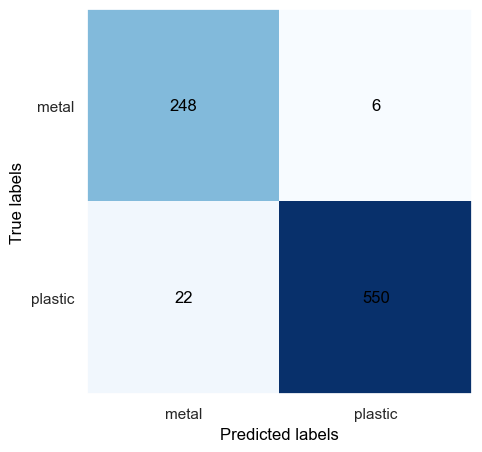

In [28]:
# Get the predicted labels for the test set
y_pred = model2.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=test_generator.classes, predictions=y_pred_labels)
cm = cm.numpy()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.xaxis.set_ticklabels(['metal', 'plastic'])
ax.yaxis.set_ticklabels(['metal', 'plastic'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

In [26]:

target_names = ['metal', 'plastic']
print(classification_report(test_generator.classes, y_pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       metal       0.92      0.98      0.95       254
     plastic       0.99      0.96      0.98       572

    accuracy                           0.97       826
   macro avg       0.95      0.97      0.96       826
weighted avg       0.97      0.97      0.97       826



### Model Conversion into TF-Lite and Optimization 

In [21]:
# Load the saved model
tf_model = tf.keras.models.load_model('Transfer_model')
tf_model.save('Transfer_model.h5') 

In [ ]:
##### converting the model in tflite and using the default optimization from tf


# Load the saved model
tf_model = tf.keras.models.load_model('Transfer_model')

# Create the converter and optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert the model to tflite
tflite_model = converter.convert()

# Save the converted model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpdo3w9pr8/assets


INFO:tensorflow:Assets written to: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpdo3w9pr8/assets
2023-04-10 05:42:39.401393: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-10 05:42:39.401429: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-10 05:42:39.401937: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpdo3w9pr8
2023-04-10 05:42:39.416882: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-04-10 05:42:39.416899: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/zd/9g9r30rx7kd536t1w5zbr6x80000gn/T/tmpdo3w9pr8
2023-04-10 05:42:39.504060: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-10 05:42:39.820274: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [196]:
## testing TF-lite model 



# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Create a test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=annotations_test,
    directory=test_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=1,  # set batch size to 1
    class_mode='categorical',
    shuffle=False)

# Iterate through the test generator and evaluate the model accuracy
correct_predictions = 0
total_predictions = 0

for images, labels in test_generator:
    # Run inference on the TFLite model
    interpreter.set_tensor(input_details[0]['index'], images)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Calculate the number of correct predictions
    correct_predictions += np.sum(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1))
    total_predictions += predictions.shape[0]

    # Exit the loop if we have processed all test images
    if total_predictions >= len(annotations_test):
        break

# Calculate the accuracy of the model
accuracy = correct_predictions / total_predictions
print("Model accuracy:", accuracy)


Found 826 validated image filenames belonging to 2 classes.
Model accuracy: 0.9673123486682809


- As we can see here the Tflite model accuracy stayed the same after being converted and optimized.
- The final step is to use deploy this model into the Raspberry pi and Test it